# Initial setup
As a first step, we import all the relevant python libraries that we will need for our analysis, such as numpy, pandas, statsmodels, and scikit-learn. Then, we import our csv dataset, using the 'read_csv()' command.
Once our dataset is loaded we can inspect the data using the head() method to have a quick look at what columns and what kind of data we have available to work with.

In [13]:
# Import Modules
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import csv
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import datetime

FILE_NAME = 'information.csv'

input_data = pd.read_csv(FILE_NAME)
display(input_data.head(5))

,customer_id,First Time,Recent Time,# of Orders,# of Orders in last 7 days,# of Orders in last 4 weeks,Amount,Amount in last 7 days,Amount in last 4 weeks,Avg_DistanceFromResturant,Avg_DeliveryTime
0,1269647,6/29/15 10:57,12/10/15 2:18,212,6.0,43.0,138808,4291,26853,1.6,51
1,167631,7/4/15 15:39,12/15/15 14:42,211,8.0,19.0,56404,1925,4177,2.2,42
2,301524,6/26/15 9:56,12/9/15 20:45,189,9.0,33.0,36020,1772,6404,2.5,57
3,1268254,7/1/15 1:51,12/14/15 1:43,184,6.0,37.0,32489,975,7110,3.1,55
4,357161,7/11/15 18:34,12/19/15 23:26,182,4.0,23.0,85150,1738,9958,2.4,36


In [12]:
print("Number of rows: ",input_data.shape[0])
counts = input_data.describe().iloc[0]
display(
    pd.DataFrame(
        counts.tolist(), 
        columns=["Count of values"], 
        index=counts.index.values
    ).transpose()
)

('Number of rows: ', 10000)


,customer_id,# of Orders,# of Orders in last 7 days,# of Orders in last 4 weeks,Amount,Amount in last 7 days,Amount in last 4 weeks,Avg_DistanceFromResturant,Avg_DeliveryTime
Count of values,10000.0,10000.0,1923.0,4341.0,10000.0,10000.0,10000.0,10000.0,10000.0


Infering Columns To Use the Row

In [41]:
input_data['First Time']=pd.to_datetime(input_data['First Time'], infer_datetime_format=True)
input_data['Recent Time']=pd.to_datetime(input_data['Recent Time'], infer_datetime_format=True)
input_data['customer_duration'] = input_data.apply(lambda x: (datetime.date.today()-x['First Time'].date()).days, axis=1)
input_data['customer_recency'] = input_data.apply(lambda x: (datetime.date.today()-x['Recent Time'].date()).days, axis=1)


In [63]:
from sklearn.decomposition import TruncatedSVD

dataframe = input_data[['# of Orders','# of Orders in last 7 days','# of Orders in last 4 weeks','Amount','Amount in last 7 days','Amount in last 4 weeks','Avg_DistanceFromResturant','Avg_DeliveryTime','customer_duration','customer_recency']]
svd = TruncatedSVD(n_components=9, n_iter=15, random_state=42)
dataframe=dataframe.dropna()
svd.fit(dataframe.values.tolist()) 
print(svd.explained_variance_ratio_)
var_ratios=svd.explained_variance_ratio_
print(svd.singular_values_)

[9.66652009e-01 2.12976432e-02 9.22612939e-03 2.80310945e-03
 1.68624620e-05 2.22752280e-06 1.94859935e-06 5.49416771e-08
 8.65440418e-09]
[4.67483462e+05 7.07909435e+04 5.09424863e+04 2.14471489e+04
 1.66243303e+03 6.04009552e+02 5.64928967e+02 9.48600674e+01
 3.76487929e+01]


In [67]:
print "get the dimensions coeff" 
" ".join([
    "%+0.3f*%s" % (coef, feat) 
    for coef, feat in zip(svd.components_[0], dataframe.columns)
])

get the dimensions coeff


'+0.002*# of Orders +0.000*# of Orders in last 7 days +0.000*# of Orders in last 4 weeks +0.971*Amount +0.061*Amount in last 7 days +0.216*Amount in last 4 weeks +0.000*Avg_DistanceFromResturant +0.002*Avg_DeliveryTime +0.057*customer_duration +0.050*customer_recency'

# Feature Selection
Based on variance results we will select 
1. customer_recency
2. customer_duration
3. Amount in last 4 weeks
4. Amount in last 7 days
5. Amount

For further analysis

In [93]:

input_data['Amount_in_last_7_days']=input_data['Amount in last 7 days']
input_data['Amount_in_last_4_weeks']=input_data['Amount in last 4 weeks']
finaldataframe = input_data[['customer_id','Amount','Amount_in_last_7_days','Amount_in_last_4_weeks','customer_duration','customer_recency']]
print "Columns Having None :",finaldataframe.columns[finaldataframe.isna().any()].tolist()

Columns Having None : []


In [94]:
finaldataframe.shape

(10000, 6)

In [95]:
finaldataframe.head()

,customer_id,Amount,Amount_in_last_7_days,Amount_in_last_4_weeks,customer_duration,customer_recency
0,1269647,138808,4291,26853,1191,1027
1,167631,56404,1925,4177,1186,1022
2,301524,36020,1772,6404,1194,1028
3,1268254,32489,975,7110,1189,1023
4,357161,85150,1738,9958,1179,1018


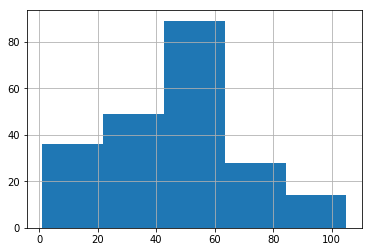

In [96]:
finaldataframe.customer_id.groupby(finaldataframe.customer_duration).nunique().hist(bins=5);

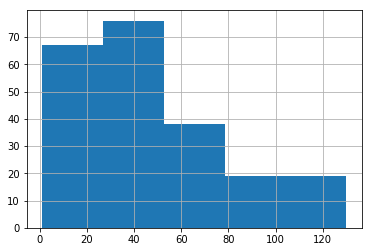

In [97]:
finaldataframe.customer_id.groupby(finaldataframe.customer_recency).nunique().hist(bins=5);

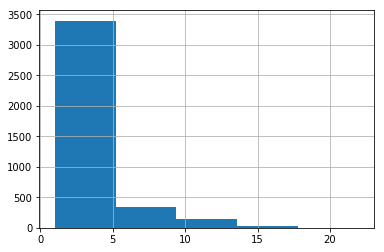

In [98]:
finaldataframe.customer_id.groupby(finaldataframe.Amount).nunique().hist(bins=5);

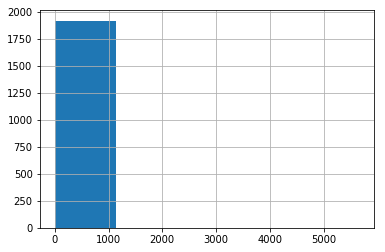

In [99]:
finaldataframe.customer_id.groupby(finaldataframe.Amount_in_last_4_weeks).nunique().hist(bins=5);

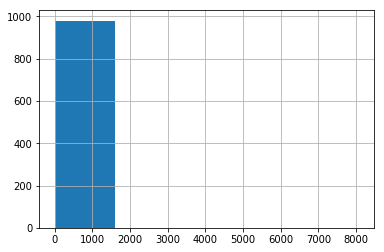

In [100]:
finaldataframe.customer_id.groupby(finaldataframe.Amount_in_last_7_days).nunique().hist(bins=5);

# Clustering of the Users

In [101]:
finaldataframe = input_data[['Amount','Amount_in_last_7_days','Amount_in_last_4_weeks','customer_duration','customer_recency']]

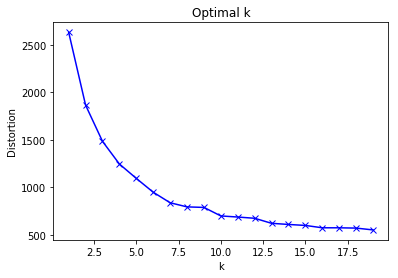

In [115]:
data_x = finaldataframe.values
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(data_x)
    kmeanModel.fit(data_x)
    distortions.append(sum(np.min(cdist(data_x, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / data_x.shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Optimal k')
plt.show()

In [116]:
FINAL_K = 9
kmeanModel = KMeans(n_clusters=FINAL_K).fit(data_x)

In [119]:
customer_labels = kmeanModel.labels_

In [118]:
finaldataframe = input_data[['customer_id','Amount','Amount_in_last_7_days','Amount_in_last_4_weeks','customer_duration','customer_recency']]

In [121]:
rows = finaldataframe.shape[0]

In [123]:
finaldataframe['cluster_id']=customer_labels

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [125]:
finaldataframe.groupby(['cluster_id']).size()

cluster_id
0     128
1    7172
2      22
3     634
4       2
5      52
6    1710
7     277
8       3
dtype: int64

In [155]:
finaldataframe['recency']=(finaldataframe.customer_recency.max()-finaldataframe['customer_recency'])*1.0/abs(finaldataframe.customer_recency.min()-finaldataframe.customer_recency.max())
finaldataframe['duration']=(finaldataframe['customer_duration']-finaldataframe.customer_duration.min())*1.0/abs(finaldataframe.customer_duration.min()-finaldataframe.customer_duration.max())
user_segmenst=finaldataframe.groupby(['cluster_id'])['Amount','Amount_in_last_7_days','Amount_in_last_4_weeks','duration','recency'].agg(['size','mean','median'])

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [156]:
user_segmenst.reset_index()

cluster_id Amount                          Amount_in_last_7_days  \
               size           mean    median                  size   
0          0    128   20856.187500   20674.0                   128   
1          1   7172     546.165923     428.5                  7172   
2          2     22   49436.136364   47128.5                    22   
3          3    634    6765.094637    6544.5                   634   
4          4      2  131828.500000  131828.5                     2   
5          5     52   32168.384615   31684.5                    52   
6          6   1710    2903.991813    2732.0                  1710   
7          7    277   12330.815884   12099.0                   277   
8          8      3   83834.000000   85150.0                     3   

                       Amount_in_last_4_weeks                        duration  \
          mean  median                   size          mean   median     size   
0   780.156250   509.0                    128   3907.289062   3161.0      128   
1    28.195482     0.0                   7172    111.035416      0.0     7172   
2  2372.181818  2108.0                     22   8795.636364   9022.0       22   
3   321.611987     0.0                    634   1387.123028   1092.0      634   
4  2145.500000  2145.5                      2  13426.500000  13426.5        2   
5  1546.538462  1165.0                     52   5892.730769   5497.5       52   
6   167.778363     0.0                   1710    655.136842    412.5     1710   
7   573.451264   227.0                    277   2512.180505   2034.0      277   
8  2116.333333  1738.0                      3  12020.000000   9958.0        3   

                      recency                      
       mean    median    size      mean    median  
0  0.804579  0.828704     128  0.821347  0.842466  
1  0.524589  0.532407    7172  0.588212  0.625571  
2  0.835227  0.854167      22  0.828767  0.849315  
3  0.735512  0.787037     634  0.785547  0.812785  
4  0.937500  0.937500       2  0.726027  0.726027  
5  0.820780  0.844907      52  0.844924  0.851598  
6  0.647918  0.708333    1710  0.736855  0.785388  
7  0.781789  0.819444     277  0.816841  0.831050  
8  0.842593  0.833333       3  0.882801  0.885845

In [143]:
abs(finaldataframe.customer_duration.min()-finaldataframe.customer_duration.max())

216

In [145]:
abs(finaldataframe.customer_recency.min())

993

In [158]:
x=finaldataframe[finaldataframe['cluster_id']==1]

In [160]:
x.Amount_in_last_7_days.median()

0.0